In [3]:
# Wave‑climate variability (2010–2024)
# -----------------------------------------------------------
# Reproduce Figs 2–4 of *Chien et al. 2014* for 2010‑2024 using:
#   • Taiwan coastal buoys (Longdong, Hualien, Hsinchu)
#   • NOAA/NDBC buoy #52200 (western Pacific reference)
#
# Directory structure assumed (edit if different):
#   /buoy
#       └── data/
#           ├── Longdong/  2010.csv … 2024.csv
#           ├── Hualien/   2010.csv … 2024.csv
#           └── Hsinchu/   2010.csv … 2024.csv
# -----------------------------------------------------------

import io, requests, warnings, re
from pathlib import Path
from typing import List, Literal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import stats
from scipy.signal import find_peaks
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr, linregress, ttest_ind
from statsmodels.tsa.stattools import ccf
from sklearn.metrics import mean_squared_error
from itertools import product
from mpl_toolkits.basemap import Basemap

In [4]:
# ------------------------------------------------------------------
# 1. Helpers to ingest local Taiwan‑CWB buoy files
# ------------------------------------------------------------------
CWB_ROOT = Path("../data")  # edit to actual root if needed
CWB_SITES = {
    "Longdong": (25.0969, 121.9222),
    "Hualien":  (24.0311, 121.6325),
    "Hsinchu":  (24.7625, 120.8422),
    "LiuqiuIsland": (22.3131, 120.3639),

}
CWB_TIME_COL = "時間" 

VARIABLE_META = {
    "Hs": {
        "cwb_col": "示性波高",
        "label": "Significant wave height",
        "unit": "m"
    },
    "Wind": {
        "cwb_col": "風速",
        "label": "Wind speed",
        "unit": "m/s"
    },
    "SST": {
        "cwb_col": "海面溫度",
        "label": "Sea surface temperature",
        "unit": "°C"
    },
    # Add more if needed
}

# Other global variables
ROLL_3M = "2190h"   # 90 days ≈ 3 months (24*90 = 2160 h, add margin)
ROLL_1Y = "8760h"   # 365 days in hours

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [5]:
def read_cwb_site(site: str, years: range | List[int] = range(2010, 2025)) -> pd.DataFrame:
    frames: List[pd.DataFrame] = []
    site_dir = CWB_ROOT / site

    for y in years:
        f = site_dir / f"{y}.csv"
        if not f.exists():
            warnings.warn(f"missing file {f}")
            continue
        df = pd.read_csv(f, skiprows=[1, 2], low_memory=False)
        df = df.rename(columns={CWB_TIME_COL: "time"})

        # Standardize names
        for std_name, meta in VARIABLE_META.items():
            if meta["cwb_col"] in df.columns:
                df = df.rename(columns={meta["cwb_col"]: std_name})

        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        df = df.dropna(subset=["time"]).set_index("time")
        df["site"] = site
        frames.append(df)

    if not frames:
        raise FileNotFoundError(f"No CSV files found for {site}")
    return pd.concat(frames).sort_index()

def plot_monthly_data(master: pd.DataFrame, var: str = "Wind"):
    """
    Plot monthly-mean time series of a given variable across all sites.
    Args:
        master: pd.DataFrame with columns including 'site' and the given var
        var: standard variable name (must be in VARIABLE_META)
    """
    if var not in VARIABLE_META:
        raise ValueError(f"Unsupported variable '{var}'. Available: {list(VARIABLE_META)}")

    meta = VARIABLE_META[var]

    fig, ax = plt.subplots(figsize=(10, 5))
    for site, grp in master.groupby("site"):
        if var not in grp.columns:
            continue  # Skip site if this variable doesn't exist
        monthly = grp[var].resample("ME").mean()
        ax.plot(monthly.index, monthly, label=site)

    ax.set_ylabel(f"{meta['label']} ({meta['unit']})")
    ax.set_title(f"Monthly-mean {meta['label']}s (2010–2024)")
    ax.legend()
    ax.grid(True, alpha=.3)
    fig.autofmt_xdate()


In [6]:
cwb_sites = [read_cwb_site(site) for site in CWB_SITES]
cwb_sites_df = pd.concat(cwb_sites).sort_index()


In [7]:
cwb_sites_df.head()

,測站編號,陣風_風速,Wind,風向,氣壓,氣溫,SST,Hs,平均週期,波向,波浪尖峰週期,流速,分層流速{深度:流速},流向,分層流向{深度:流向},流速(節),潮高,site
time,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,Vector_CWB_FB_46694A,6.6,4.6,65.0,1021.9,14.9,18.1,1.50,6.3,56.0,8.7,NaN,NaN,NaN,NaN,NaN,NaN,Longdong
2010-01-01 00:00:00,Vector_CWB_FB_46714D,6.7,4.8,3.0,1019.3,18.8,25.3,0.44,4.4,292.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,LiuqiuIsland
2010-01-01 00:00:00,Vector_CWB_FB_46757B,11.2,8.7,32.0,1021.2,13.5,18.0,1.31,5.1,NaN,7.4,NaN,NaN,NaN,NaN,NaN,NaN,Hsinchu
2010-01-01 00:00:00,Vector_CWB_FB_46699A,5.2,3.0,296.0,1022.5,16.7,22.3,1.20,5.4,56.0,8.7,NaN,NaN,NaN,NaN,NaN,NaN,Hualien
2010-01-01 01:00:00,Vector_CWB_FB_46694A,6.4,4.3,69.0,1021.8,15.0,18.1,1.83,6.4,90.0,9.5,NaN,NaN,NaN,NaN,NaN,NaN,Longdong


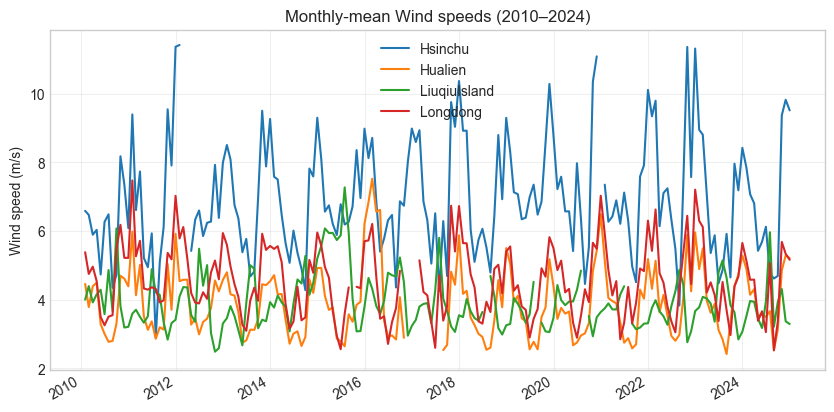

In [7]:
# plt.style.use("seaborn-v0_8-colorblind")
plot_monthly_data(cwb_sites_df, "Wind")


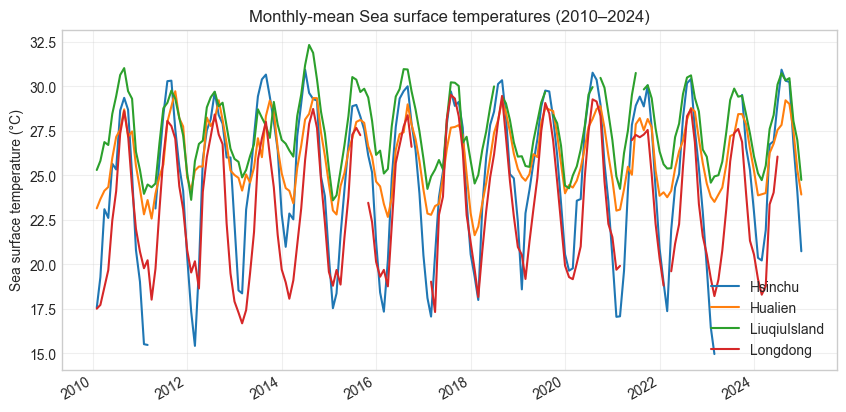

In [8]:
plot_monthly_data(cwb_sites_df, "SST")

In [8]:
# ------------------------------------------------------------------
# 2. Helpers to fetch NOAA/NDBC buoy 52200
# ------------------------------------------------------------------
NDBC_ID = "52200"
NDBC_BASE = "https://www.ndbc.noaa.gov/view_text_file.php"
NDBC_DIR = "../data/NOAA"

NDBC_COLS = ["year","month","day","hour","minute",
             "WDIR","WSPD","GST","WVHT","DPD","APD",
             "MWD","PRES","ATMP","WTMP","DEWP","VIS","TIDE"]

In [9]:
# Fetch NDBC buoy data (cached locally after first download)
def load_or_download_ndbc(buoy: str, year: int) -> pd.DataFrame:
    local_dir = Path(f"{NDBC_DIR}/buoy_{buoy}") 
    local_dir.mkdir(parents=True, exist_ok=True)                  
    local_path = local_dir / f"{buoy}h{year}.txt"
    if not local_path.exists():
        params = {
            "filename": f"{buoy}h{year}.txt.gz",
            "dir": "data/historical/stdmet/",
        }
        r = requests.get(NDBC_BASE, params=params, timeout=60)
        r.raise_for_status()
        text = r.text
        local_path.write_text(text)
    else:
        text = local_path.read_text()

    lines = [ln for ln in text.splitlines() if not ln.lstrip().startswith('#')]
    if not lines:
        raise ValueError(f"No data for {buoy} {year}")
    df = pd.read_csv(io.StringIO("\n".join(lines)), sep=r'\s+',
                     names=NDBC_COLS, na_values={99.0,999.0,99.00,9999.0})
    # rename to lowercase for pandas datetime
    df = df.rename(columns={
        'WSPD':'Wind', 'WVHT':'Hs', 'WDIR':'Dir', 'WTMP':'SST',
    })
    df['time'] = pd.to_datetime(df[['year','month','day','hour','minute']], errors='coerce')
    df = df.set_index('time').sort_index()
    return df[['Hs','Wind','Dir','SST']].assign(site=f"NDBC_{buoy}")


def read_ndbc(buoy: str, years: range | List[int] = range(2010, 2025)) -> pd.DataFrame:
    frames = [load_or_download_ndbc(buoy, y) for y in years]
    return pd.concat(frames)

# ------------------------------------------------------------------
# 3. Build combined dataset (lazy – fetch once & cache locally)
# ------------------------------------------------------------------
def build_master(NOAA_buoy: List[str] = []) -> pd.DataFrame:
    """Return a single DataFrame with index‑aligned hourly data from all sites."""
    frames = [read_cwb_site(site) for site in CWB_SITES]
    for buoy in NOAA_buoy:
        frames.append(read_ndbc(buoy))
    return pd.concat(frames).sort_index()


In [10]:
master_df = build_master(NOAA_buoy=[NDBC_ID])
print(master_df.head())

                                     測站編號  陣風_風速  Wind     風向      氣壓    氣溫  \
time                                                                          
2010-01-01 00:00:00  Vector_CWB_FB_46694A    6.6   4.6   65.0  1021.9  14.9   
2010-01-01 00:00:00  Vector_CWB_FB_46757B   11.2   8.7   32.0  1021.2  13.5   
2010-01-01 00:00:00  Vector_CWB_FB_46714D    6.7   4.8    3.0  1019.3  18.8   
2010-01-01 00:00:00  Vector_CWB_FB_46699A    5.2   3.0  296.0  1022.5  16.7   
2010-01-01 00:21:00                   NaN    NaN   NaN    NaN     NaN   NaN   

                      SST    Hs  平均週期     波向  波浪尖峰週期  流速  分層流速{深度:流速}  流向  \
time                                                                        
2010-01-01 00:00:00  18.1  1.50   6.3   56.0     8.7 NaN          NaN NaN   
2010-01-01 00:00:00  18.0  1.31   5.1    NaN     7.4 NaN          NaN NaN   
2010-01-01 00:00:00  25.3  0.44   4.4  292.0     8.0 NaN          NaN NaN   
2010-01-01 00:00:00  22.3  1.20   5.4   56.0     8.7 NaN     

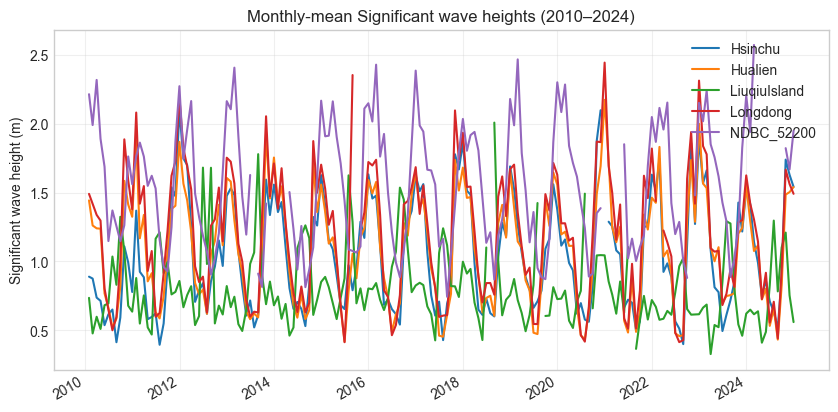

In [12]:
plot_monthly_data(master_df, "Hs")

In [13]:
# Visualize variable across sites on separate scales
def plot_multi_scale(df: pd.DataFrame,
                     var: Literal['Hs','Wind','Dir','SST'],
                     clip_min: float | None = 0, clip_max: float | None = None):
    # only CWB sites
    sites = [s for s in df['site'].unique() if not s.startswith('NDBC_')]
    fig,axes = plt.subplots(len(sites),1,
                            figsize=(12,3*len(sites)),
                            sharex=True)
    for ax,site in zip(axes,sites):
        s = df.loc[df['site']==site, var]
        if clip_max is not None:
            s = s.where(s < clip_max)
        ax.plot(s, color='gray', alpha=0.3, label='Hourly')
        ax.plot(s.rolling(ROLL_3M).mean(), label='90D mean')
        ax.plot(s.rolling(ROLL_1Y).mean(), label='365D mean')
        ax.set_title(site)
        ax.set_ylim(clip_min, clip_max or None)
        ax.legend()

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))        
    fig.suptitle(f'{var} multi-scale variation', y=0.95)
    plt.tight_layout(rect=[0,0,1,0.93])

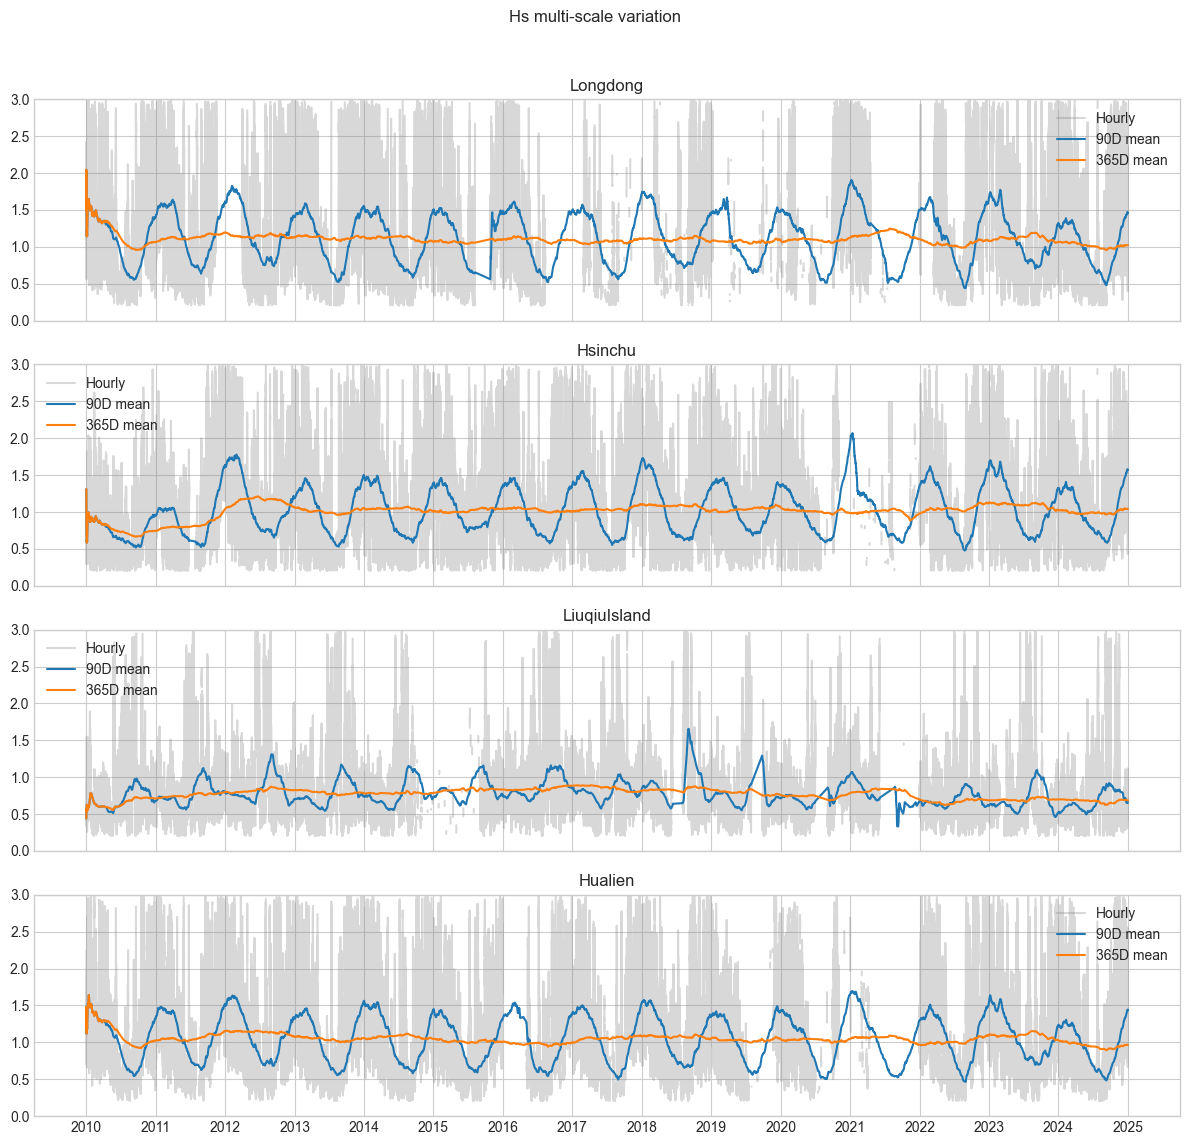

In [14]:
plot_multi_scale(master_df, 'Hs', clip_max=3.0)

In [15]:
def plot_monthly_data_split(master: pd.DataFrame,
                            var: str = "Hs",
                            clip_min: float | None = 0,
                            clip_max: float | None = None):
    """
    Plot monthly and annual-mean values of a variable by site, in subplots.
    
    Args:
        master: pd.DataFrame with a 'site' column and variable columns
        var: standard variable name (must be in VARIABLE_META)
        clip_min: optional lower y-limit (default 0)
        clip_max: optional upper y-limit
    """
    if var not in VARIABLE_META:
        raise ValueError(f"Unsupported variable '{var}'")

    meta = VARIABLE_META[var]
    sites = sorted(master["site"].unique())
    fig, axes = plt.subplots(len(sites), 1, figsize=(12, 3 * len(sites)), sharex=True)

    if len(sites) == 1:
        axes = [axes]

    for ax, site in zip(axes, sites):
        group = master[master["site"] == site]
        if var not in group.columns:
            continue

        monthly = group[var].resample("ME").mean()
        yearly  = group[var].resample("YE").mean()

        if clip_max is not None:
            monthly = monthly.where(monthly < clip_max)
            yearly  = yearly.where(yearly < clip_max)

        ax.plot(monthly.index, monthly, label="Monthly mean", color="steelblue")
        ax.plot(yearly.index, yearly, label="Annual mean", color="firebrick")
        ax.set_ylabel(f"{meta['unit']}")
        ax.set_title(f"{site}")
        ax.legend(loc="upper left")
        ax.set_ylim(clip_min or None, clip_max)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    fig.suptitle(f"Monthly and annual mean {meta['label']} (2010–2024)", y=0.93)
    plt.tight_layout(rect=[0, 0, 1, 0.91])


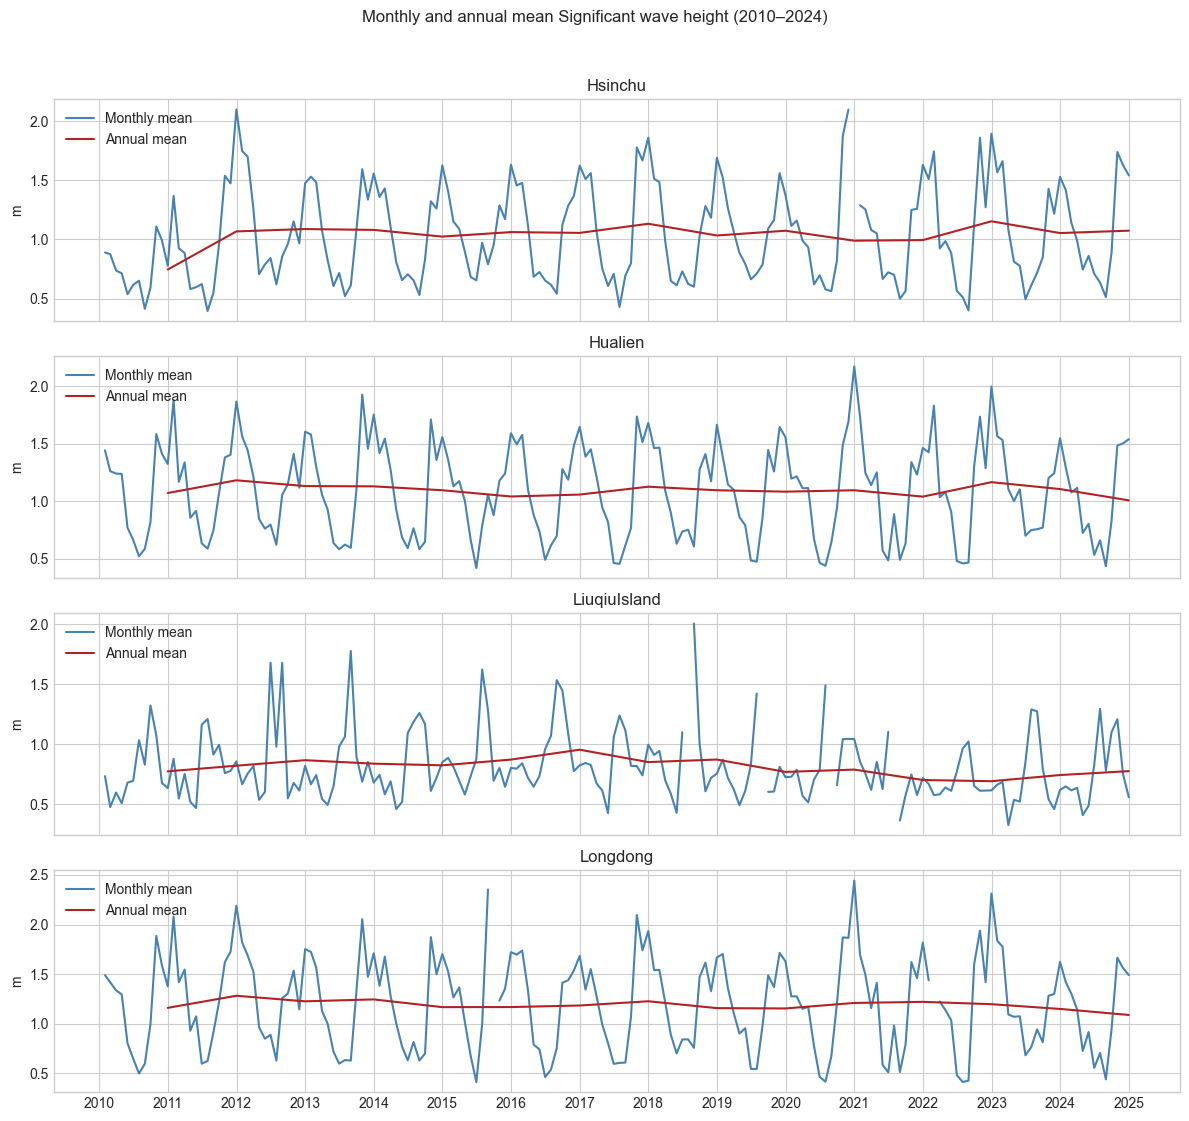

In [16]:
plot_monthly_data_split(cwb_sites_df, "Hs")

In [ ]:
# plot_multi_scale(master_df, 'SST', clip_min=15)

In [ ]:
# plot_monthly_data_split(master_df, "SST")

In [11]:
def plot_seasonal_data(data: pd.DataFrame, var: str = "Hs"):
    for site, group in data.groupby('site'):
        df = group.copy()
        df['month'] = df.index.month
        monthly_means = df.groupby('month')[var].mean()
        
        plt.plot(monthly_means.index, monthly_means.values, 'o-', label=site, linewidth=2)

    meta = VARIABLE_META[var]    
    plt.title(f"Seasonal {meta['label']} Patterns")
    plt.xlabel('Month')
    plt.ylabel(f"Mean {meta['label']} ({meta['unit']})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 13))

def plot_year_trend(data: pd.DataFrame, var: str = "Hs"):
    for site, group in data.groupby('site'):
        annual = group[var].resample('YS').mean()
        years = annual.index.year
        
        plt.plot(years, annual.values, 'o-', label=site, linewidth=2)
        
        # Add trend line
        if len(annual) > 5:
            z = np.polyfit(years, annual.values, 1)
            p = np.poly1d(z)
            plt.plot(years, p(years), '--', alpha=0.7)
    
        meta = VARIABLE_META[var]    
    plt.title(f"Annual Mean {meta['label']} with Trends")
    plt.xlabel('Year')
    plt.ylabel(f"Annual Mean {meta['label']} ({meta['unit']})")
    plt.legend()
    plt.grid(True, alpha=0.3)

def build_daily_series(master, site, var="Hs"):
    s = master.loc[master["site"] == site, var]
    daily = s.resample("D").mean()
    daily = daily.interpolate("time", limit=2).dropna()
    return daily

def plot_daily_series(master: pd.DataFrame, site: str, var: str = "Hs"):
    daily = build_daily_series(master, site, var)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(daily.index, daily.values, label=f"{site} {var}", color="steelblue")
    
    # Add rolling mean
    rolling_mean = daily.rolling(window=90).mean()
    ax.plot(rolling_mean.index, rolling_mean.values, label="90-day rolling mean", color="firebrick", alpha=0.7)
    
    meta = VARIABLE_META[var]
    ax.set_title(f"Daily {meta['label']} for {site} (2010–2024)")
    ax.set_xlabel("Date")
    ax.set_ylabel(f"{meta['label']} ({meta['unit']})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()


def plot_seasonal_trend(master: pd.DataFrame, site: str, var: str = "Hs"):
    daily = build_daily_series(master, site, var)
    
    # Seasonal decomposition
    stl = STL(daily, period=365, robust=True).fit()
    meta = VARIABLE_META[var]
    fig = stl.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"Seasonal Decomposition of {meta['label']} for {site} ({meta['unit']})", y=0.95)
    plt.suptitle(f"Seasonal and Trend Analysis for {site} ({var})", y=0.95)
    plt.tight_layout()
    plt.show()
    

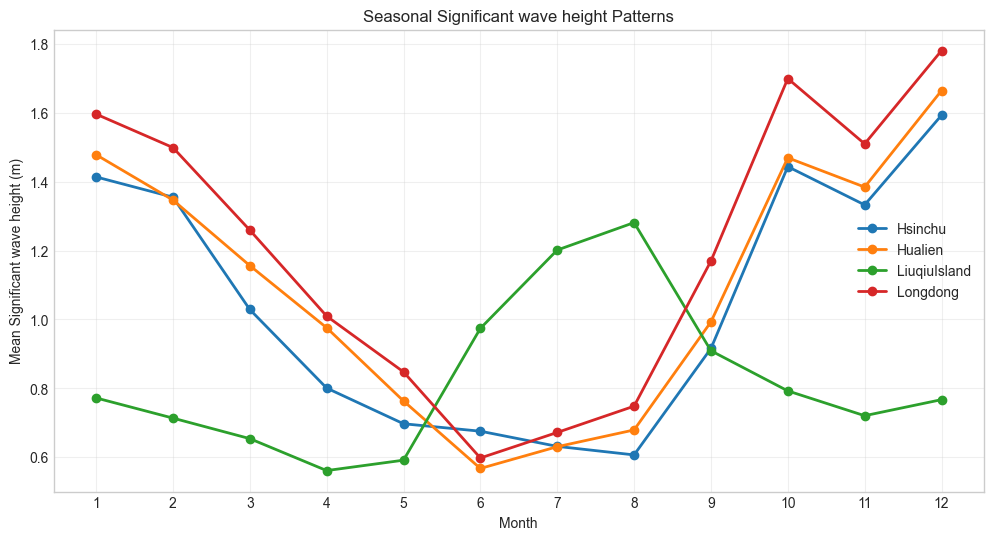

In [18]:
plot_seasonal_data(cwb_sites_df, "Hs")

In [ ]:
# plot_seasonal_data(cwb_sites_df, "SST")

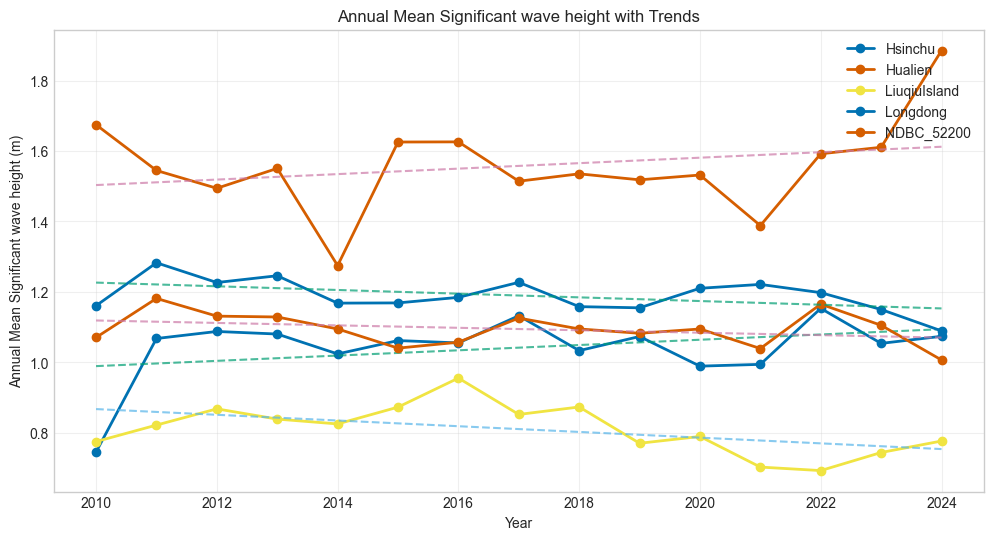

In [20]:
plot_year_trend(master_df, "Hs")

In [ ]:
# plot_year_trend(master_df, "SST")

In [ ]:
# plot_daily_series(master_df, 'Longdong', 'Hs')

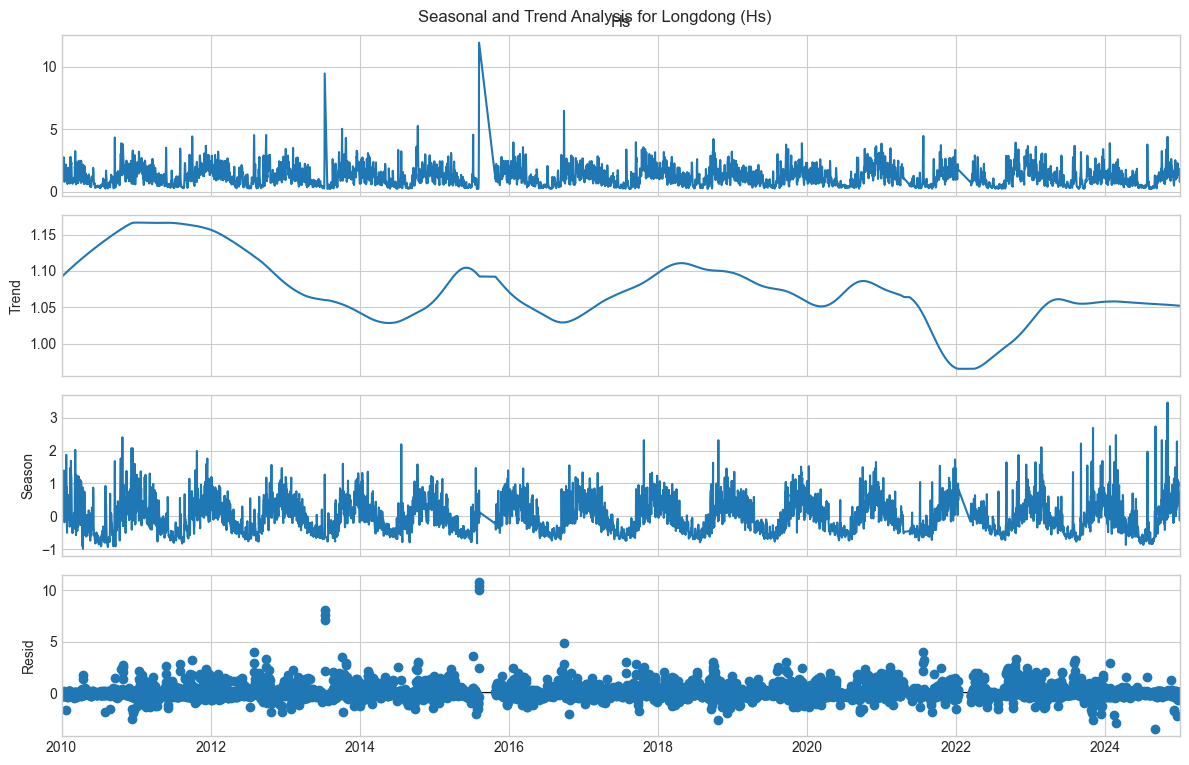

In [19]:
plot_seasonal_trend(cwb_sites_df, 'Longdong', "Hs")

In [ ]:
# plot_daily_series(master_df, 'Longdong', 'SST')

In [ ]:
# plot_seasonal_trend(cwb_sites_df, 'Longdong', "SST")

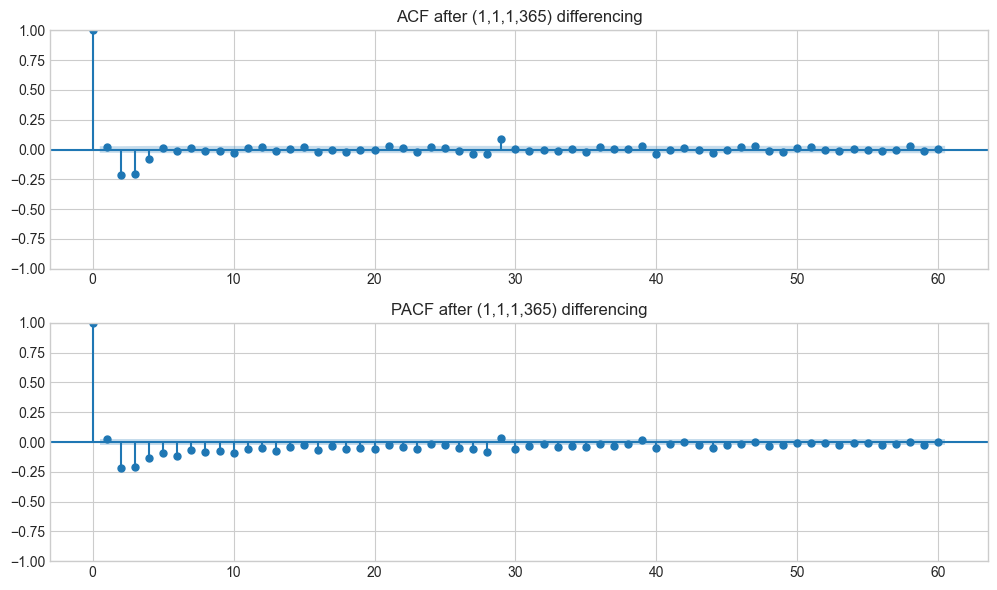

In [12]:
# Daily Hs series and differencing to inspect ARIMA orders
daily = build_daily_series(cwb_sites_df, 'Longdong', 'Hs')
# 一階非季節 & 一階季節差分
y = daily.diff().dropna()          # d=1
y = y.diff(365).dropna()           # D=1, s=365

fig, axes = plt.subplots(2,1,figsize=(10,6))
plot_acf(y, lags=60, ax=axes[0])
plot_pacf(y, lags=60, ax=axes[1])
axes[0].set_title("ACF after (1,1,1,365) differencing")
axes[1].set_title("PACF after (1,1,1,365) differencing")
plt.tight_layout()
plt.show()

In [13]:
# Fit SARIMAX on one year to keep runtime manageable
# Use 2023 daily Hs at Longdong as training and forecast 2024
monthly = daily.resample("MS").mean()
start_yr = '2013'
end_yr = '2023'
mod = SARIMAX(
    monthly[start_yr:end_yr],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
fc_mon = mod.get_forecast(12).predicted_mean

# resid1 = mod.resid
print(mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 Hs   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -59.180
Date:                            Wed, 25 Jun 2025   AIC                            128.360
Time:                                    22:41:24   BIC                            141.630
Sample:                                01-01-2013   HQIC                           133.737
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1989      0.153      1.301      0.193      -0.101       0.499
ma.L1         -1.0000    567.611   

In [14]:
# ----------------------------------------------------------------------------
# Fit SARIMAX by AIC‐grid‐search (no pmdarima)
# ----------------------------------------------------------------------------
def select_sarimax_model(
    series,
    s: int = 12,
    p_max: int = 2, d: int = 1, q_max: int = 2,
    P_max: int = 1, D: int = 1, Q_max: int = 1,
):
    """
    Brute‐force SARIMAX(p,d,q)(P,D,Q,s) selection by AIC.
    Returns the fitted results instance with lowest AIC.
    """
    best_aic = np.inf
    best_res = None
    for p, q, P, Q in product(range(p_max+1), range(q_max+1),
                              range(P_max+1), range(Q_max+1)):
        try:
            mod = SARIMAX(
                series,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_res = res
        except Exception:
            continue
    return best_res

In [ ]:
# Apply to your daily Hs series
print("Selecting SARIMAX by AIC—this may take a minute…")
sarimax_res = select_sarimax_model(monthly[start_yr:end_yr])

# Summary of best model
print(sarimax_res.summary())

# Extract residuals
# resid2 = sarimax_res.resid

Selecting SARIMAX by AIC—this may take a minute…


d:\Python\py313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\py313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                   Hs   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -56.409
Date:                              Tue, 24 Jun 2025   AIC                            122.818
Time:                                      22:32:44   BIC                            136.040
Sample:                                  01-01-2013   HQIC                           128.174
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3026      0.291     -1.039      0.299      -0.874       0.269
ma.L1         -0.30

d:\Python\py313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


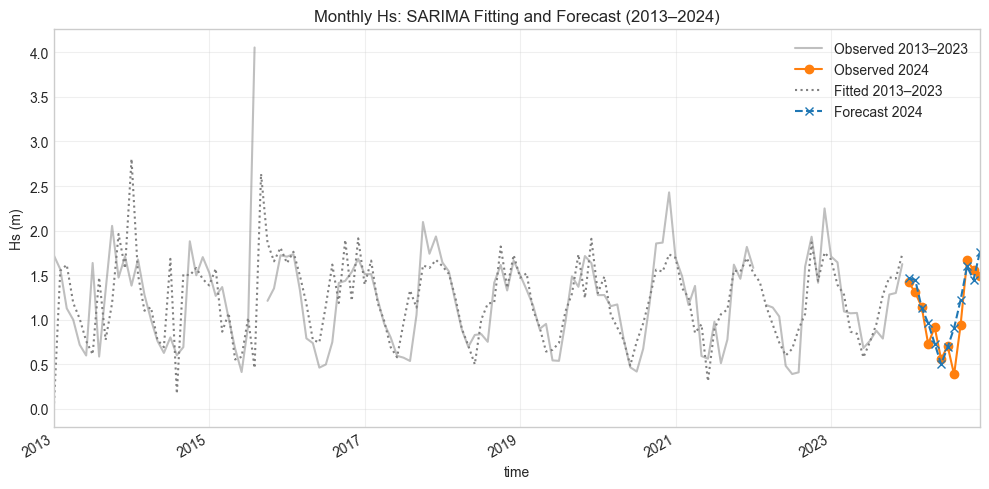

In [42]:
# Assuming:
# - `monthly` is your full monthly mean series (2010–2024)
# - `fc_mon` is the 12-month SARIMA forecast for 2024


# Extract series
train_obs = monthly[start_yr:end_yr]
true_2024 = monthly['2024']
fitted_2020_2023 = sarimax_res.fittedvalues
fc_mon = sarimax_res.get_forecast(12).predicted_mean


# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Observed data
train_obs.plot(ax=ax, label=f"Observed {start_yr}–{end_yr}", color="gray", alpha=0.5)
true_2024.plot(ax=ax, label="Observed 2024", color="tab:orange", marker="o")

# Fitted values
fitted_2020_2023.plot(ax=ax, label=f"Fitted {start_yr}–{end_yr}", color="gray", linestyle=":")

# Forecast
fc_mon.plot(ax=ax, label="Forecast 2024", color="tab:blue", linestyle="--", marker="x")

# Styling
ax.set_title(f"Monthly Hs: SARIMA Fitting and Forecast ({start_yr}–2024)")
ax.set_ylabel("Hs (m)")
ax.legend()
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()



Ljung-Box test results:       lb_stat  lb_pvalue
10  14.219874   0.163197
20  24.586082   0.217728
30  34.534710   0.259963


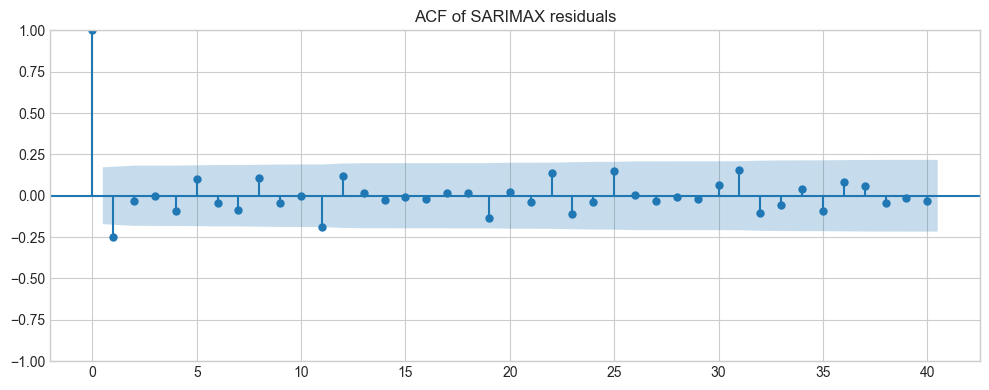

In [45]:
# Plot ACF of residuals
residuals = mod.resid
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_acf(residuals.dropna(), lags=40, ax=ax)
ax.set_title("ACF of SARIMAX residuals")

# Perform Ljung-Box test
ljung_box = acorr_ljungbox(residuals.dropna(), lags=[10, 20, 30], return_df=True)
print("Ljung-Box test results:", ljung_box)

plt.tight_layout()
plt.show()

Ljung-Box test results:       lb_stat  lb_pvalue
10   9.630748   0.473464
20  19.997526   0.458084
30  28.323345   0.553307


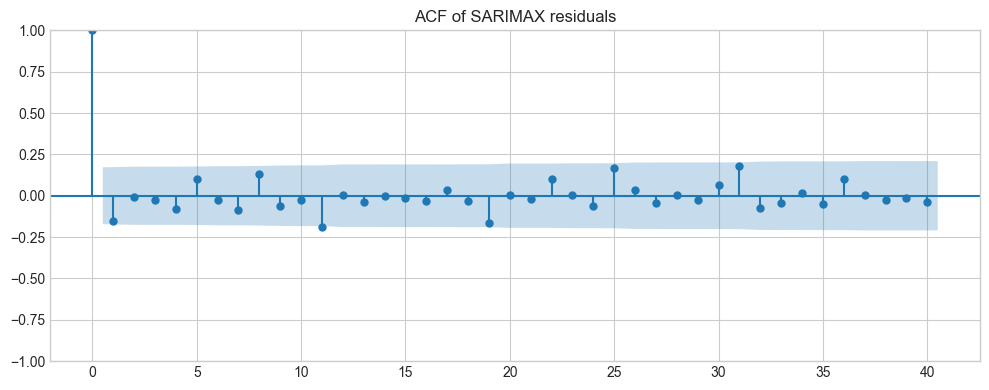

In [46]:
# Plot ACF of residuals
residual2 = sarimax_res.resid
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_acf(residual2.dropna(), lags=40, ax=ax)
ax.set_title("ACF of SARIMAX residuals")

# Perform Ljung-Box test
ljung_box = acorr_ljungbox(residual2.dropna(), lags=[10, 20, 30], return_df=True)
print("Ljung-Box test results:", ljung_box)

plt.tight_layout()
plt.show()

In [15]:
# Utility to fetch monthly SOI index
def get_soi_data(start=2010, end=2024):
    """
    Download standardized monthly SOI index from NOAA.
    start and end can be:
      - 4-digit year (e.g., 2010)
      - or 6-digit year+month (e.g., 201003 for March 2010)
    """
    def to_timestamp(val, default_month):
        """Convert 4- or 6-digit year/month to pd.Timestamp"""
        val = int(val)
        if val < 10000:
            return pd.Timestamp(year=val, month=default_month, day=15)
        else:
            return pd.Timestamp(year=val // 100, month=val % 100, day=15)

    # Normalize start and end to Timestamps
    start_ts = to_timestamp(start, default_month=1)
    end_ts   = to_timestamp(end,   default_month=12)

    try:
        url = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
        response = requests.get(url, timeout=30)
        lines = response.text.strip().split('\n')

        # === Step 1: Locate standardized SOI section
        for i, line in enumerate(lines):
            if "STANDARDIZED" in line:
                start_idx = i + 2
                break
        else:
            raise ValueError("Standardized SOI section not found")

        # === Step 2: Parse monthly data
        data = []
        for line in lines[start_idx:]:
            line = re.sub(r'(?<=[0-9])-(?=[0-9])', ' -', line)
            parts = line.split()
            if not parts or not parts[0].isdigit():
                continue
            year = int(parts[0])
            if len(parts) < 13:
                continue
            for m in range(1, 13):
                try:
                    val = float(parts[m])
                    if val == -999.9:
                        continue
                    date = pd.Timestamp(year, m, 15)
                    if start_ts <= date <= end_ts:
                        data.append({"date": date, "SOI": val})
                except ValueError:
                    continue

        return pd.DataFrame(data).set_index("date")

    except Exception as e:
        print("Using synthetic SOI due to error:", e)
        dates = pd.date_range(start_ts, end_ts, freq="MS")
        t = np.arange(len(dates))
        soi = 2 * np.sin(2*np.pi*t/24) + np.random.normal(0, 0.5, len(dates))
        return pd.DataFrame({'SOI': soi}, index=dates)


In [16]:
stl = STL(daily, period=365, robust=True).fit()
resid = stl.resid
resid_m = resid.rolling(30, center=True).mean().dropna()    

In [17]:
soi = get_soi_data()
soi_daily = soi["SOI"].resample("D").ffill().reindex(daily.index, method="ffill")


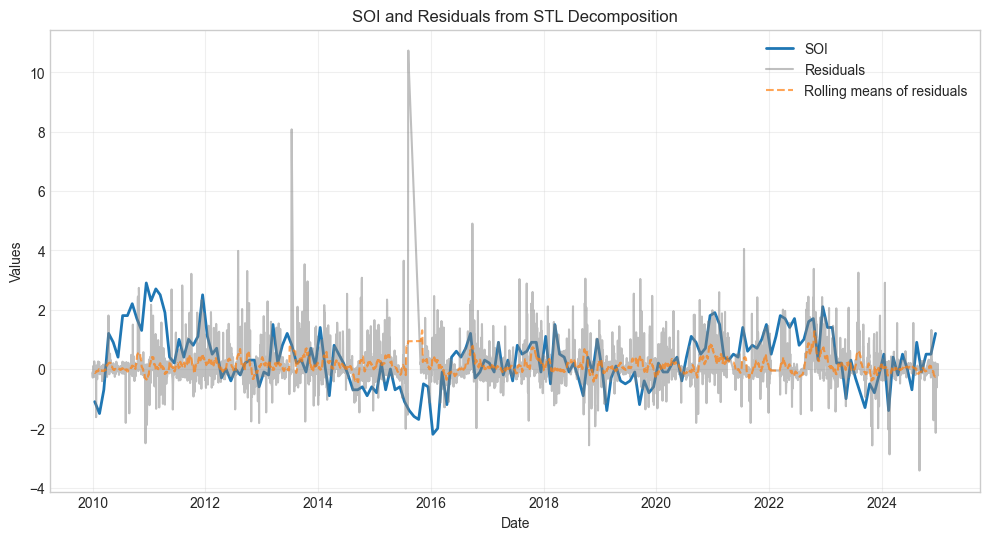

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(soi.index, soi['SOI'], label='SOI', linewidth=2)
ax.plot(daily.index, resid, label='Residuals', color='gray', alpha=0.5)
#ax.plot(soi_daily.index, soi_daily.values, label='SOI Daily', linestyle='--', alpha=0.7)
ax.plot(resid_m.index, resid_m, label='Rolling means of residuals', linestyle='--', alpha=0.7)
ax.set_title("SOI and Residuals from STL Decomposition")
ax.set_xlabel("Date")
ax.set_ylabel("Values")
ax.legend()
ax.grid(True, alpha=0.3)

In [ ]:
# Decompose SOI to remove seasonal cycle
soi_stl = STL(soi, period=12, robust=True).fit()
soi_resid = soi_stl.resid


In [29]:
len(soi_resid)
print(soi_resid)

date
2010-01-15   -0.080608
2010-02-15   -0.047449
2010-03-15   -0.269143
2010-04-15    0.093045
2010-05-15    0.081752
                ...   
2024-08-15    0.464660
2024-09-15    0.059745
2024-10-15   -0.058293
2024-11-15    0.178786
2024-12-15    0.016860
Name: resid, Length: 180, dtype: float64


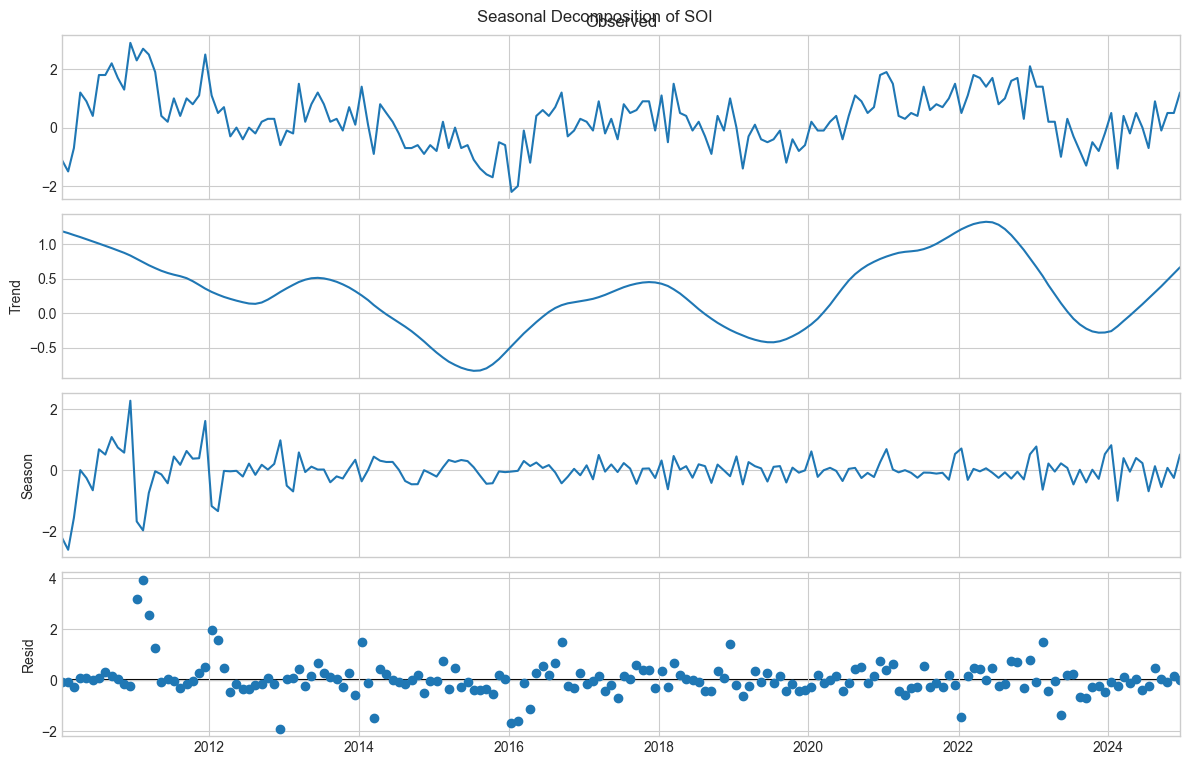

In [20]:
if True:
    fig = soi_stl.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"Seasonal Decomposition of SOI", y=0.95)
    plt.tight_layout()
    plt.show()
    

In [33]:
# Correlation using monthly anomalies instead of STL residuals
hs_monthly = daily.resample('MS').mean()
hs_anom = hs_monthly - hs_monthly.mean()
soi_monthly = soi.resample('MS').mean()
soi_anom = soi_monthly['SOI'] - soi_monthly['SOI'].mean()
anom = hs_anom.to_frame('hs').join(soi_anom.to_frame('soi'), how='inner').dropna()
r1, p1 = pearsonr(anom['hs'], anom['soi'])
print(f'Monthly anomaly correlation r={r1:.3f}, p={p1:.4f}')


Monthly anomaly correlation r=0.045, p=0.5494


In [65]:
s = master_df.loc[master_df["site"] == "Longdong", "Hs"]
s_daily = s.resample("D").mean()
print(s_daily)

time
2010-01-01    1.490833
2010-01-02    0.847083
2010-01-03    1.355000
2010-01-04    0.885000
2010-01-05    2.523333
                ...   
2024-12-27    1.649583
2024-12-28    1.799583
2024-12-29    1.463333
2024-12-30    0.776667
2024-12-31    1.069583
Freq: D, Name: Hs, Length: 5479, dtype: float64


In [66]:
s_rolling = s.rolling("72h").mean()
print(s_rolling)

time
2010-01-01 00:00:00    1.500000
2010-01-01 01:00:00    1.665000
2010-01-01 02:00:00    1.800000
2010-01-01 03:00:00    1.882500
2010-01-01 04:00:00    1.970000
                         ...   
2024-12-31 19:00:00    1.105139
2024-12-31 20:00:00    1.104167
2024-12-31 21:00:00    1.107500
2024-12-31 22:00:00    1.110139
2024-12-31 23:00:00    1.103194
Name: Hs, Length: 370983, dtype: float64


In [34]:
from PyEMD import EEMD
import matplotlib.pyplot as plt
import numpy as np

def plot_eemd_decomposition(master_df: pd.DataFrame, site: str, var: str = "Hs", max_imfs: int = None):
    """
    Decompose daily-mean time series using EEMD and plot IMFs + trend.
    Parameters:
        master_df: full hourly dataset from build_master()
        site: site name (e.g., 'Longdong', 'Hualien')
        var: variable name (default: 'Hs')
        max_imfs: if specified, truncate the number of plotted IMFs
    """
    # Step 1: extract daily series and interpolate
    s = master_df.loc[master_df["site"] == site, var]
    s_roll = s.rolling("72h").mean()
    daily = s_roll.resample("D").mean()
    daily = daily.interpolate("time", limit=2).dropna()
    
    if daily.isna().sum() > 0 or len(daily) < 3000:
        raise ValueError("Too many gaps or not enough valid data for EEMD")

    x = daily.values
    t = np.arange(len(x))

    # Step 2: perform EEMD
    eemd = EEMD(trials=100, noise_width=0.2)
    #IMFs = eemd.eemd(x, t)
    #residual = x - IMFs.sum(axis=0)
    eemd.eemd(x, t)
    IMFs, residual = eemd.get_imfs_and_residue()

    # Step 3: plot
    n_imfs = IMFs.shape[0] if max_imfs is None else min(IMFs.shape[0], max_imfs)
    fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(12, 2.2*(n_imfs+1)), sharex=True)

    for i in range(n_imfs):
        axes[i].plot(daily.index, IMFs[i], label=f"IMF {i+1}")
        axes[i].legend(loc="upper right")
        axes[i].grid(alpha=0.3)

    axes[-1].plot(daily.index, residual, 'k', label="Residual (trend)")
    axes[-1].legend(loc="upper right")
    axes[-1].grid(alpha=0.3)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    fig.suptitle(f"EEMD decomposition of daily {var} at {site}")
    fig.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.show()
    return daily, IMFs, residual

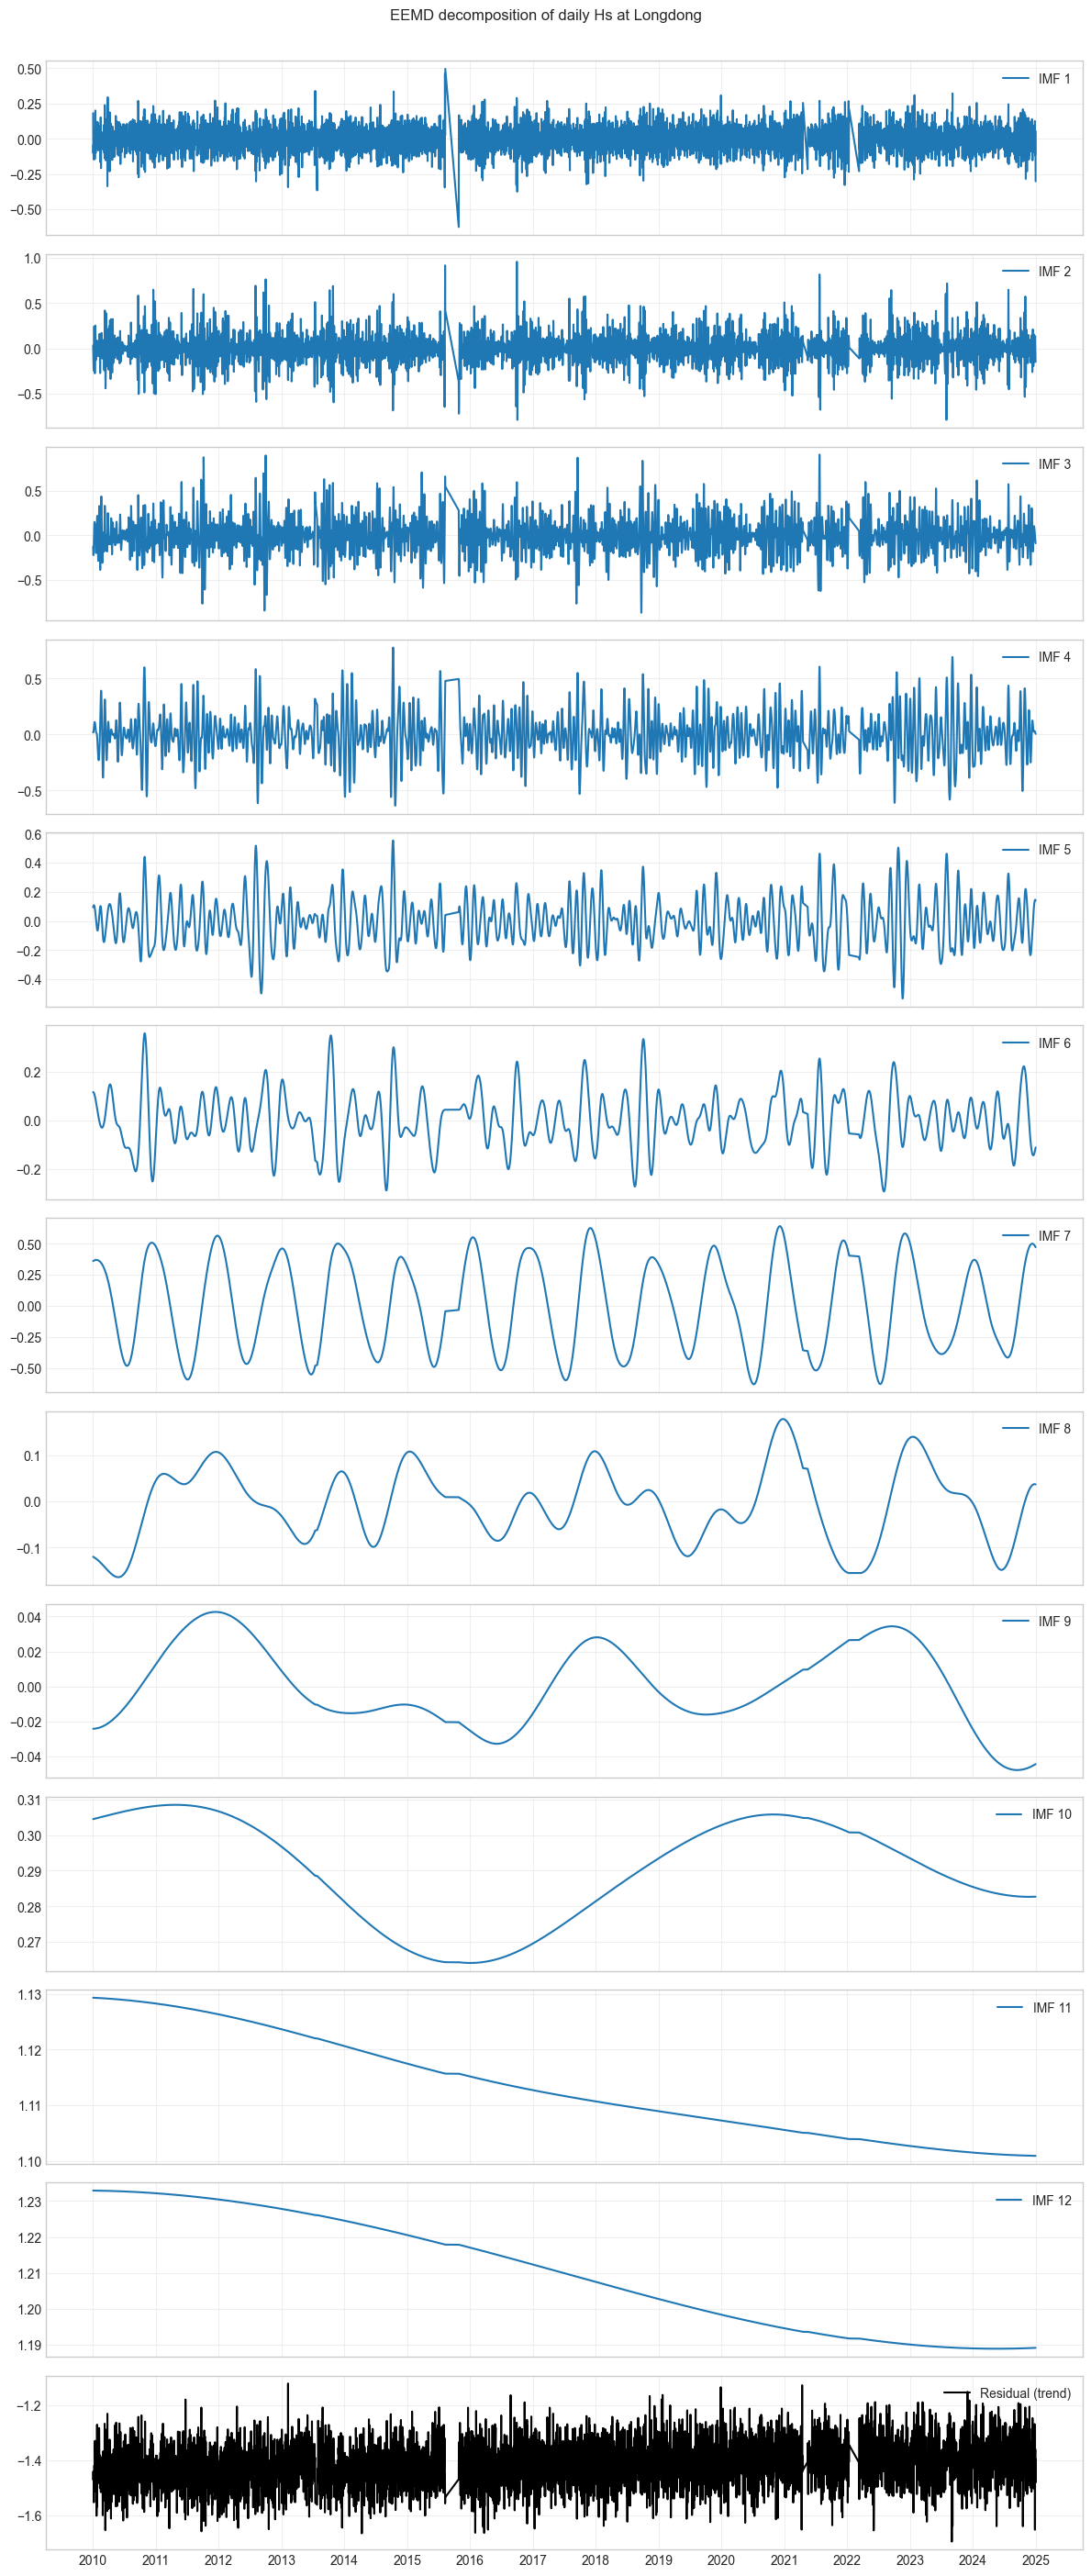

In [35]:
daily_Ld, IMF_Ld, res_Ld = plot_eemd_decomposition(master_df, 'Longdong', 'Hs')

In [36]:
def imf_fft_peak_periods(IMFs: np.ndarray,
                         dt: float = 1.0,
                         to_months: bool = True) -> pd.DataFrame:
    """
    For each IMF (row in IMFs), compute its FFT power spectrum,
    find the frequency with maximum power (excluding zero),
    and return the corresponding period.
    
    Args:
        IMFs: array shaped (n_imfs, n_samples)
        dt: sampling interval in days
        to_months: if True, convert period (days) to months≈30d
        
    Returns:
        DataFrame with columns:
          IMF (1-based index), peak_freq (cycles/day),
          peak_period_d (days), peak_period_m (months, if to_months)
    """
    n_imfs, N = IMFs.shape
    freqs = np.fft.rfftfreq(N, d=dt)            # cycles per day
    out = []
    for i, imf in enumerate(IMFs, start=1):
        P = np.abs(np.fft.rfft(imf))**2
        # ignore DC at index 0:
        idx = np.argmax(P[1:]) + 1
        f = freqs[idx]                          # cycles/day
        pdays = 1/f if f>0 else np.inf
        pmonth = pdays/30 if to_months else np.nan
        out.append({"IMF": i,
                    "peak_freq_cpd": f,
                    "peak_period_d": pdays,
                    "peak_period_m": pmonth})
    return pd.DataFrame(out)


In [37]:
fft_stats = imf_fft_peak_periods(IMF_Ld, dt=1.0, to_months=True)
print(fft_stats)

    IMF  peak_freq_cpd  peak_period_d  peak_period_m
0     1       0.208891       4.787196       0.159573
1     2       0.131286       7.616930       0.253898
2     3       0.057826      17.293160       0.576439
3     4       0.032775      30.511494       1.017050
4     5       0.015445      64.743902       2.158130
5     6       0.008099     123.465116       4.115504
6     7       0.002825     353.933333      11.797778
7     8       0.000942    1061.800000      35.393333
8     9       0.000565    1769.666667      58.988889
9    10       0.000377    2654.500000      88.483333
10   11       0.000188    5309.000000     176.966667
11   12       0.000188    5309.000000     176.966667


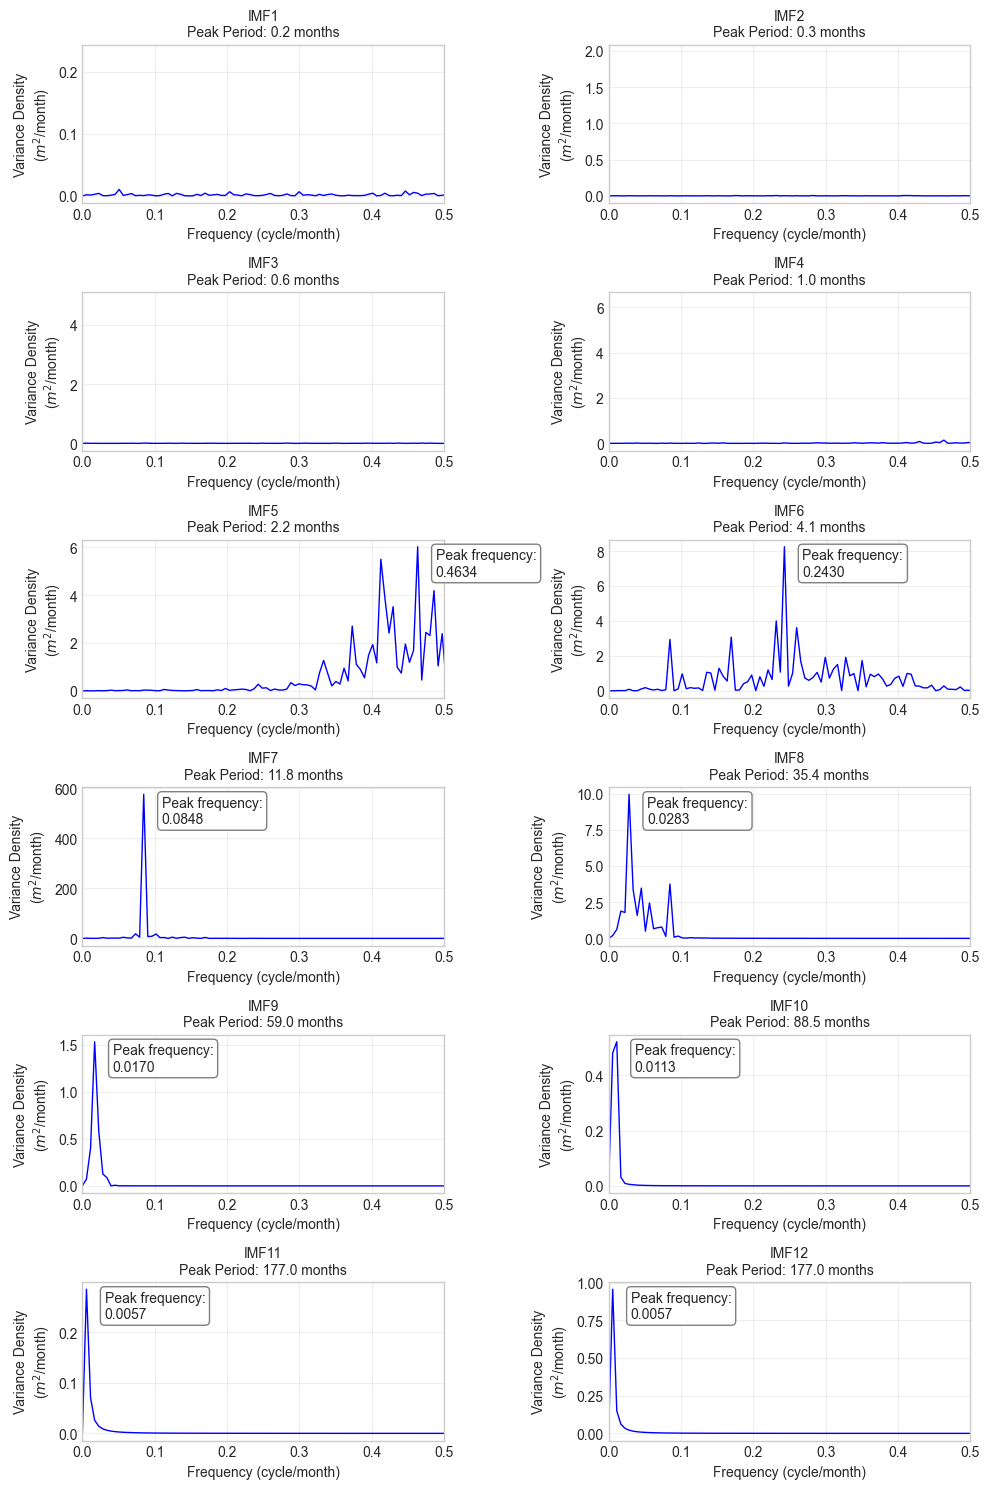

In [38]:
from scipy.signal import periodogram

# Simulated IMF data (for demo, replace with your real IMF matrix)
# np.random.seed(0)
# t = np.arange(0, 3650)  # 10 years of daily data
# IMFs = [np.sin(2 * np.pi * t / p) + 0.1 * np.random.randn(len(t)) for p in [90, 120, 180, 240, 365, 512, 730, 1000]]

# Plot IMF FFTs
n = len(IMF_Ld)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2.5 * nrows))
axes = axes.ravel()

for i, imf in enumerate(IMF_Ld):
    f, Pxx = periodogram(imf, fs=1.0)  # fs=1 sample/day
    freq_monthly = f * 30  # cycles/month
    ax = axes[i]
    ax.plot(freq_monthly, Pxx, color='blue', lw=1)
    ax.set_xlim(0, 0.5)
    ax.set_xlabel("Frequency (cycle/month)")
    ax.set_ylabel("Variance Density\n($m^2$/month)")

    # Estimate peak period
    peak_idx = np.argmax(Pxx[1:]) + 1  # skip DC
    peak_freq = freq_monthly[peak_idx]
    peak_period = 1 / peak_freq if peak_freq > 0 else np.nan

    if peak_freq > 0 and peak_freq < 0.5:
        ax.text(peak_freq + 0.025, Pxx.max()*0.8,  # x and y placement
                f"Peak frequency:\n{peak_freq:.4f}",
                fontsize=10, bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'),
                transform=ax.transData)
    ax.set_title(f"IMF{i+1}\nPeak Period: {peak_period:.1f} months", fontsize=10)
    ax.grid(True, alpha=0.3)

for i in range(len(IMF_Ld), len(axes)):
    axes[i].axis("off")

plt.tight_layout()


In [39]:
def enso_imf_correlation(fft_stats: pd.DataFrame,
                          IMFs: np.ndarray,
                          daily_idx: pd.DatetimeIndex,
                          soi: pd.Series,
                          low_m: float = 12,
                          high_m: float = 60):
    """
    Sum IMFs whose peak_period_m lies in [low_m, high_m],
    resample to monthly, align with SOI, then correlate+plot.
    """
    # 1) pick IMF numbers (1-based) in ENSO band
    ensos = fft_stats.query("@low_m <= peak_period_m <= @high_m")["IMF"].tolist()
    if not ensos:
        raise ValueError("No IMFs in ENSO band")
    
    # 2) sum them
    sel = [i-1 for i in ensos]
    s = IMFs[sel].sum(axis=0)
    ser = pd.Series(s, index=daily_idx, name="IMF_ENSO")
    
    # 3) smooth by 30D, then monthly means
    ser_m = ser.rolling("30D", center=True).mean().resample("MS").mean()
    
    # 4) align with SOI (monthly)
    soi_m = soi.resample("MS").mean()
    df = pd.DataFrame({"IMF_ENSO": ser_m, "SOI": soi_m}).dropna()
    
    # 5) corr + plot
    r, p = pearsonr(df["IMF_ENSO"], df["SOI"])
    
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df["IMF_ENSO"], label="IMF3+4+5", color="steelblue")
    plt.plot(df.index, df["SOI"], label="SOI", color="darkorange")
    plt.title(f"Sum(IMF{ensos}) vs SOI → r={r:.2f}  p={p:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df, r, p


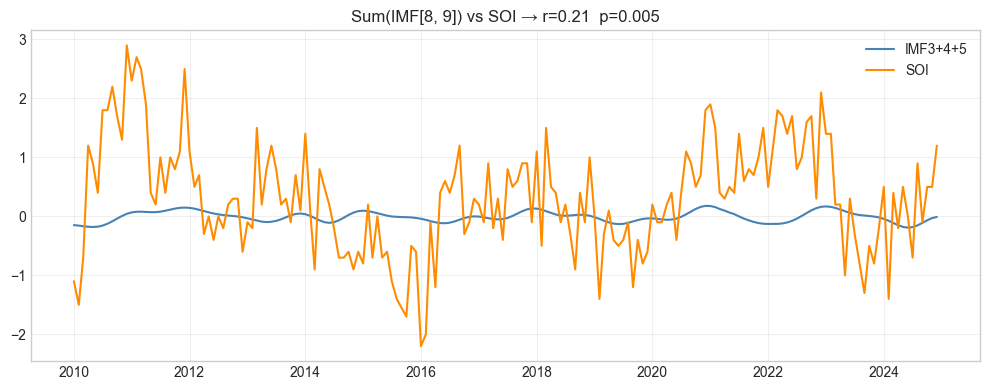

In [40]:
# 1) compute FFT stats
fft_stats = imf_fft_peak_periods(IMF_Ld, dt=1.0, to_months=True)

# 2) load your SOI monthly series (get_soi_data())
soi = get_soi_data()["SOI"]

# 3) call
df_corr, r, p = enso_imf_correlation(
    fft_stats, IMF_Ld, daily_Ld.index, soi,
    low_m=12, high_m=60
)


In [73]:
print(df_corr, r, p)

            IMF_ENSO       SOI
2010-01-01 -0.153930  0.245980
2010-02-01 -0.163653  0.916353
2010-03-01 -0.172997  0.140010
2010-04-01 -0.179529  2.592950
2010-05-01 -0.179573  2.600019
...              ...       ...
2024-08-01 -0.157658  2.266055
2024-09-01 -0.121968  1.747284
2024-10-01 -0.084320  1.086382
2024-11-01 -0.053084  0.685817
2024-12-01 -0.035867  0.133749

[178 rows x 2 columns] -0.19190997804759555 0.01028021993641699


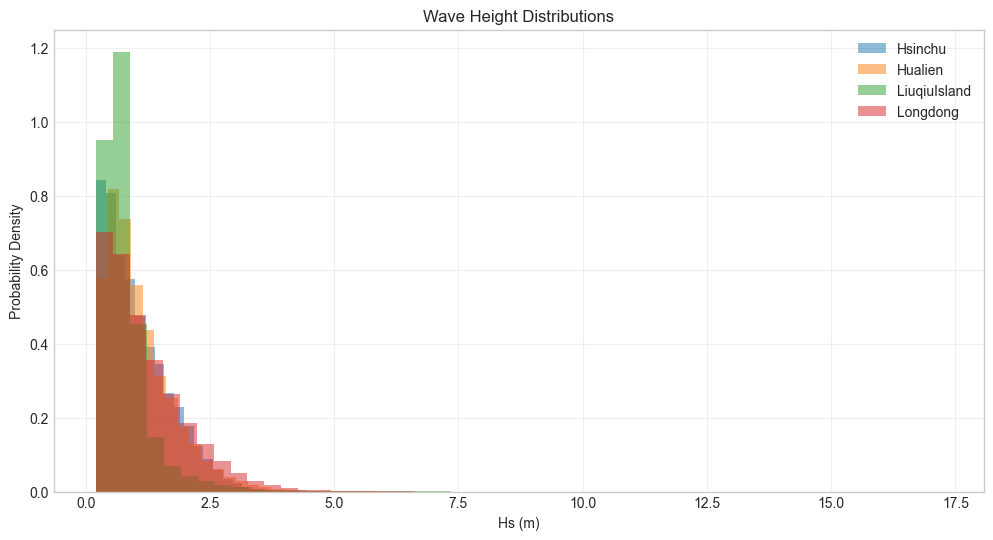

In [86]:
#Wave height distributions
fig, ax = plt.subplots(figsize=(12, 6))
for site, group in cwb_sites_df.groupby('site'):
    hs_clean = group['Hs'].dropna()
    plt.hist(hs_clean, bins=50, alpha=0.5, label=site, density=True)
    
plt.title('Wave Height Distributions')
plt.xlabel('Hs (m)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)

In [25]:
s = master_df.loc[master_df["site"] == "Longdong", "Hs"]
threadshold = 3.0
is_ext = s > threadshold
print(s[is_ext].count(), f"extreme events in Longdong Hs > {threadshold} m")

4112 extreme events in Longdong Hs > 3.0 m


In [42]:
def detect_extreme_events(master_df: pd.DataFrame,
                          site: str,
                          var: str = "Hs",
                          threshold: float = 6.0,
                          min_duration_hrs: int = 5) -> pd.DataFrame:
    """
    Detect extreme-wave events for a given site:
      - var > threshold
      - duration at least min_duration_hrs (hours)
    Returns a DataFrame of events with columns:
      [start, end, duration_hours, season]
    """
    # Filter site series
    s = master_df.loc[master_df["site"] == site, var]
    is_ext = s > threshold
    
    # Identify contiguous runs via group id
    grp = (is_ext != is_ext.shift()).cumsum()
    df = pd.DataFrame({"is_ext": is_ext, "grp": grp})
    
    events = []
    for gid, chunk in df.groupby("grp"):
        if not chunk["is_ext"].iloc[0]:
            continue
        # duration in hours = number of rows (hourly data)
        duration_hrs = len(chunk)
        if duration_hrs < min_duration_hrs:
            continue
        start = chunk.index[0]
        end   = chunk.index[-1]
        # classify season by start month
        m = start.month
        if m in (11,12,1,2,3):
            season = "winter"
        elif m in (5,6,7,8,9):
            season = "summer"
        else:
            season = "other"
        events.append({
            "start": start, "end": end,
            "duration_hrs": duration_hrs,
            "season": season,
            "year": start.year
        })
    return pd.DataFrame(events)


def plot_extreme_event_counts(events_df: pd.DataFrame,
                              year_min: int = None,
                              year_max: int = None,
                              ax: plt.Axes = None):
    """
    Plot number of extreme events per year by season (red=summer, blue=winter).
    """
    df = events_df.copy()
    if year_min is not None:
        df = df[df["year"] >= year_min]
    if year_max is not None:
        df = df[df["year"] <= year_max]

    counts = df.groupby(["year", "season"]).size().unstack(fill_value=0)

    years = np.arange(counts.index.min(), counts.index.max() + 1)
    winter = counts.get("winter", pd.Series(0, index=counts.index)).reindex(years, fill_value=0)
    summer = counts.get("summer", pd.Series(0, index=counts.index)).reindex(years, fill_value=0)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,4))
    ax.bar(years, winter, color="steelblue", alpha=0.7, label="Winter")
    ax.bar(years, summer, color="indianred", alpha=0.7, label="Summer")
    ax.set_xlim(years.min()-0.5, years.max()+0.5)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Extreme Events")
    ax.legend()
    ax.grid(alpha=0.3)
    return ax



In [43]:
events = detect_extreme_events(master_df, "Longdong", threshold=4.0, min_duration_hrs=4)
print(events)

                 start                 end  duration_hrs  season  year
0  2010-09-19 02:00:00 2010-09-19 11:00:00            10  summer  2010
1  2010-10-22 01:00:00 2010-10-22 07:00:00             7   other  2010
2  2010-10-26 18:00:00 2010-10-26 22:00:00             5   other  2010
3  2010-10-28 16:00:00 2010-10-28 21:00:00             6   other  2010
4  2010-12-16 03:00:00 2010-12-16 06:00:00             4  winter  2010
5  2011-01-15 20:00:00 2011-01-16 01:00:00             6  winter  2011
6  2011-05-28 12:00:00 2011-05-28 15:00:00             4  summer  2011
7  2011-08-05 20:00:00 2011-08-05 23:00:00             4  summer  2011
8  2011-10-03 04:00:00 2011-10-03 15:00:00            12   other  2011
9  2011-10-03 19:00:00 2011-10-04 01:00:00             7   other  2011
10 2011-10-04 07:00:00 2011-10-04 10:00:00             4   other  2011
11 2012-08-01 18:00:00 2012-08-02 01:00:00             8  summer  2012
12 2012-09-28 13:00:00 2012-09-29 04:00:00            16  summer  2012
13 201

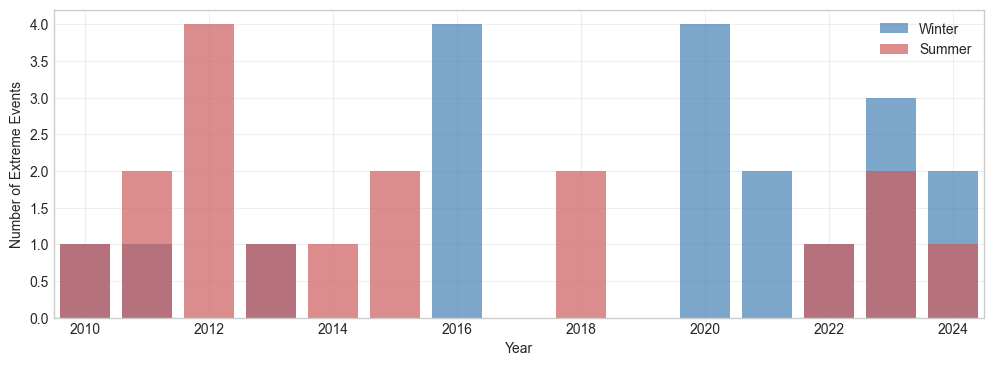

In [65]:
ax = plot_extreme_event_counts(events)

In [44]:
def plot_event_soi_overlay(events: pd.DataFrame, soi: pd.Series, pdo: pd.Series):
    """
    Plot per-month extreme event counts as side-by-side bars for summer/winter,
    overlaid with a SOI line.
    """
    # keep only summer & winter
    ev = events[events['season'].isin(['summer', 'winter'])].copy()
    # month start timestamp
    ev['month'] = ev['start'].dt.to_period('M').dt.to_timestamp()

    # counts by month and season
    monthly = ev.groupby(['month', 'season']).size().unstack(fill_value=0)
    # ensure both columns exist
    for col in ['summer', 'winter']:
        if col not in monthly:
            monthly[col] = 0
    monthly = monthly.sort_index()

    # prepare bar positions
    months = monthly.index.to_pydatetime()
    x = mdates.date2num(months)
    # width in days
    total_width = 20  # days
    sw = total_width / 2
    # offsets for side-by-side
    summer_x = x - sw/2
    winter_x = x + sw/2

    # start plot
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.bar(summer_x, monthly['summer'], width=sw, label='Summer', color='indianred', alpha=0.7)
    ax1.bar(winter_x, monthly['winter'], width=sw, label='Winter', color='steelblue', alpha=0.7)

    ax1.set_ylabel('Extreme events')
    ax1.set_xlim(x.min() - 30, x.max() + 30)
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # overlay SOI
    ax2 = ax1.twinx()
    ax2.plot(soi.index, soi.values, color='black', lw=1.5, label='SOI')
    ax2.set_ylabel('SOI index', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    ax3 = ax2.twinx()
    ax3.plot(pdo.index, pdo, label='PDO', color='orange', linewidth=2)

    # legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title('Monthly extreme wave events vs SOI (summer & winter only)')
    fig.tight_layout()
    plt.show()

In [45]:
def get_pdo_data(start=2010, end=2024):
    """Generate PDO-like index for demonstration."""
    dates = pd.date_range(f'{start}-01-01', f'{end}-12-31', freq='MS')
    t = np.arange(len(dates))
    # PDO has longer periods than ENSO
    pdo = 1.5 * np.sin(2*np.pi*t/120) + 0.8*np.sin(2*np.pi*t/84) + np.random.normal(0, 0.3, len(dates))
    return pd.DataFrame({'PDO': pdo}, index=dates)

In [46]:
soi = get_soi_data(2010, 2024)

In [47]:
pdo = get_pdo_data(2010, 2024)

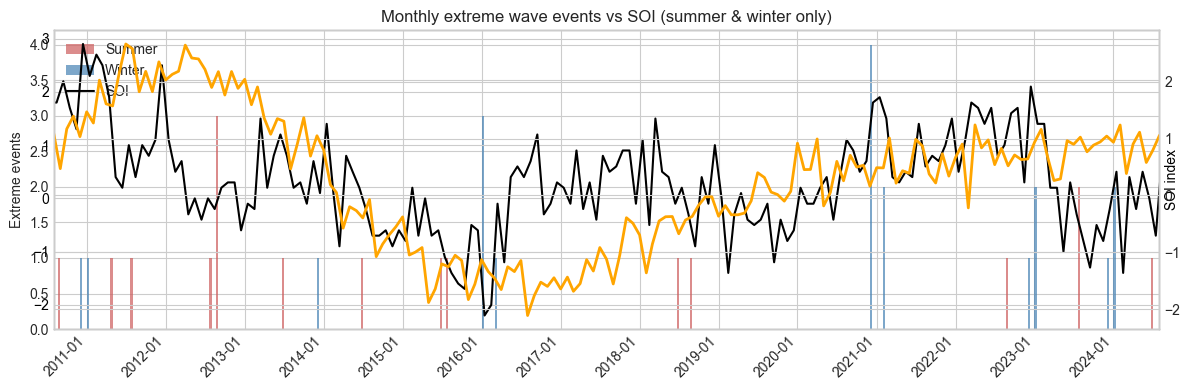

In [48]:
plot_event_soi_overlay(events, soi["SOI"], pdo['PDO'])

In [49]:
# Retry with manual haversine implementation since `haversine` package is unavailable
# Haversine formula to calculate distance between two lat/lon points
def haversine_manual(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Earth radius in km

    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

In [ ]:
# Load once (the IBTrACS WP best track data again)
'''
csv_path = "d:/backup/data/ibtracs.WP.list.v04r01.csv"
cols = ['SID', 'NAME', 'ISO_TIME', 'LAT', 'LON', 'USA_WIND']
bt = pd.read_csv(csv_path, usecols=cols, low_memory=False)

# Parse time and filter by years 2010–2025
bt['ISO_TIME'] = pd.to_datetime(bt['ISO_TIME'], errors='coerce')
bt = bt[(bt['ISO_TIME'].dt.year >= 2010) & (bt['ISO_TIME'].dt.year <= 2025)]
bt['LAT'] = pd.to_numeric(bt['LAT'], errors='coerce')
bt['LON'] = pd.to_numeric(bt['LON'], errors='coerce')
bt = bt.dropna(subset=['LAT', 'LON'])
print(f"Loaded {len(bt)}, and data: ", bt.head())
'''

Loaded 29268, and data:                    SID     NAME            ISO_TIME  LAT    LON USA_WIND
215961  2010018N07113  UNNAMED 2010-01-18 00:00:00  6.9  113.2       15
215962  2010018N07113  UNNAMED 2010-01-18 03:00:00  7.0  113.1       18
215963  2010018N07113  UNNAMED 2010-01-18 06:00:00  7.1  113.0       20
215964  2010018N07113  UNNAMED 2010-01-18 09:00:00  7.3  112.9       23
215965  2010018N07113  UNNAMED 2010-01-18 12:00:00  7.5  112.7       25


C:\Users\bioer\AppData\Local\Temp\ipykernel_7856\1872011639.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bt['ISO_TIME'] = pd.to_datetime(bt['ISO_TIME'], errors='coerce')


In [ ]:
# Compute once: the distance to Hualien manually
'''
station = CWB_SITES["Hualien"] #(24.0311, 121.6325)
#　print(f"Calculating distances to {station}...")
bt['dist_km'] = bt.apply(lambda row: haversine_manual(station, (row['LAT'], row['LON'])), axis=1)
'''

In [ ]:
# bt.to_csv('../data/typhoon_events_2010-202506.csv')

In [51]:
bt = pd.read_csv('../data/typhoon_events_2010-202506.csv')
print("typhoon events loaded:", len(bt), bt.head)

typhoon events loaded: 29268 <bound method NDFrame.head of        Unnamed: 0            SID     NAME             ISO_TIME   LAT    LON  \
0          215961  2010018N07113  UNNAMED  2010-01-18 00:00:00   6.9  113.2   
1          215962  2010018N07113  UNNAMED  2010-01-18 03:00:00   7.0  113.1   
2          215963  2010018N07113  UNNAMED  2010-01-18 06:00:00   7.1  113.0   
3          215964  2010018N07113  UNNAMED  2010-01-18 09:00:00   7.3  112.9   
4          215965  2010018N07113  UNNAMED  2010-01-18 12:00:00   7.5  112.7   
...           ...            ...      ...                  ...   ...    ...   
29263      245224  2025174N23146    SEPAT  2025-06-23 12:00:00  27.0  143.0   
29264      245225  2025174N23146    SEPAT  2025-06-23 15:00:00  27.7  142.5   
29265      245226  2025174N23146    SEPAT  2025-06-23 18:00:00  28.4  141.9   
29266      245227  2025174N23146    SEPAT  2025-06-23 21:00:00  28.9  141.4   
29267      245228  2025174N23146    SEPAT  2025-06-24 00:00:00  29.3  14

In [52]:
# Filter those within 300 km
bt_near = bt[bt['dist_km'] < 300].copy()
print(f"Loaded {len(bt_near)}, and data: ", bt_near.head())

Loaded 538, and data:       Unnamed: 0            SID      NAME             ISO_TIME   LAT    LON  \
346      216307  2010239N15118  LIONROCK  2010-09-01 00:00:00  22.3  119.5   
347      216308  2010239N15118  LIONROCK  2010-09-01 03:00:00  22.6  119.4   
348      216309  2010239N15118  LIONROCK  2010-09-01 06:00:00  22.8  119.2   
349      216310  2010239N15118  LIONROCK  2010-09-01 09:00:00  23.0  119.0   
350      216311  2010239N15118  LIONROCK  2010-09-01 12:00:00  23.2  118.9   

    USA_WIND     dist_km  
346       50  290.812138  
347       53  278.007554  
348       55  283.444538  
349       55  291.863980  
350       55  293.324921  


In [53]:
# Get the closest point per storm
closest = bt_near.loc[bt_near.groupby("SID")["dist_km"].idxmin()].copy()
closest = closest[['SID', 'NAME', 'ISO_TIME', 'LAT', 'LON', 'dist_km', 'USA_WIND']]
closest = closest.rename(columns={'ISO_TIME': 'closest_date'})
closest['closest_date'] = pd.to_datetime(closest['closest_date'])

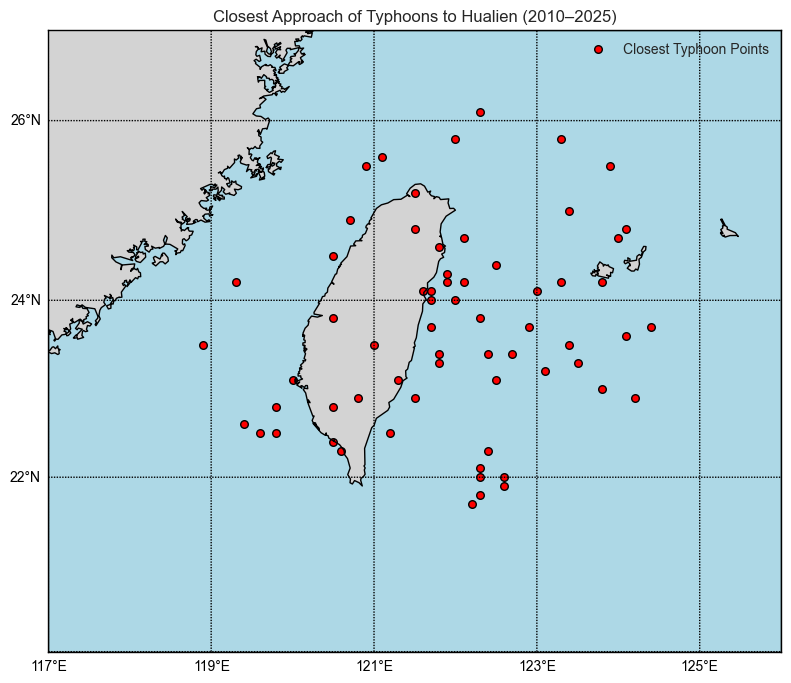

,SID,NAME,closest_date,LAT,LON,dist_km,USA_WIND
347,2010239N15118,LIONROCK,2010-09-01 03:00:00,22.6,119.4,278.007554,53
468,2010241N25125,NAMTHEUN,2010-08-30 21:00:00,25.6,121.1,182.543726,40
569,2010249N24125,MERANTI,2010-09-07 12:00:00,22.0,122.3,235.952161,20
670,2010256N17137,FANAPI,2010-09-19 00:00:00,23.7,121.7,37.451008,105
1436,2011140N08142,SONGDA,2011-05-28 00:00:00,23.0,123.8,248.963771,100


In [54]:
# Plot map of closest approach points
fig, ax = plt.subplots(figsize=(8, 8))
m = Basemap(projection='merc',
            llcrnrlon=117, llcrnrlat=20,
            urcrnrlon=126, urcrnrlat=27,
            resolution='i', ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawparallels(np.arange(20, 28, 2), labels=[1,0,0,0])
m.drawmeridians(np.arange(117, 127, 2), labels=[0,0,0,1])

# Storm closest points
x, y = m(closest['LON'].values, closest['LAT'].values)
m.scatter(x, y, c='red', s=30, edgecolors='k', label='Closest Typhoon Points')

plt.title("Closest Approach of Typhoons to Hualien (2010–2025)")
plt.legend()
plt.tight_layout()
plt.show()

closest.head()


In [55]:
def plot_event_soi_overlay(
    events: pd.DataFrame,
    soi: pd.Series,
    pdo: pd.Series,
    typhoon_df: pd.DataFrame | None = None,
    wind_scale: float = 20.0
):
    """
    Plot monthly extreme wave event counts (summer/winter) as side-by-side bars,
    overlaid with SOI, PDO, and typhoon occurrence segments.

    Parameters:
    -----------
    events : DataFrame
        Must contain:
          - 'start'   : datetime of event onset
          - 'season'  : 'summer' or 'winter'
    soi : Series
        Monthly SOI index (DatetimeIndex).
    pdo : Series
        Monthly PDO index (DatetimeIndex).
    typhoon_df : DataFrame, optional
        Must contain:
          - 'closest_date' : datetime of closest approach
          - 'USA_WIND'     : wind speed (string or numeric)
    wind_scale : float
        Divisor to scale USA_WIND into bar-chart height units.
    """
    # 1) Prepare events
    ev = events[events['season'].isin(['summer','winter'])].copy()
    ev['month'] = ev['start'].dt.to_period('M').dt.to_timestamp()
    monthly = ev.groupby(['month','season']).size().unstack(fill_value=0)
    for c in ('summer','winter'):
        if c not in monthly.columns:
            monthly[c] = 0
    monthly = monthly.sort_index()

    # 2) Bar positions
    months = monthly.index.to_pydatetime()
    x = mdates.date2num(months)
    total_w = 20
    sw = total_w/2
    sx, wx = x - sw/2, x + sw/2

    # 3) Plot bars
    fig, ax = plt.subplots(figsize=(12,4))
    # 5) Overlay PDO
    ax.spines['right'].set_position(('outward', 60))
    ax.plot(pdo.index, pdo.values, color='orange', lw=1.5, label='PDO')
    ax.set_ylabel('PDO index', color='orange')
    ax.tick_params(axis='y', labelcolor='orange')

    # 4) Overlay SOI
    ax2 = ax.twinx()
    ax2.plot(soi.index, soi.values, 'k-', lw=1.2, label='SOI')
    ax2.set_ylabel('SOI index', color='k')
    ax2.tick_params(axis='y', labelcolor='k')

    ax1 = ax2.twinx()
    # 6) Overlay typhoon segments
    if typhoon_df is not None and not typhoon_df.empty:
        ty = typhoon_df.copy()
        ty['wind'] = pd.to_numeric(ty['USA_WIND'], errors='coerce')
        ty = ty.dropna(subset=['closest_date', 'wind'])
        ty['closest_date'] = pd.to_datetime(ty['closest_date'])
        ty['h'] = ty['wind'] / wind_scale

        for _, r in ty.iterrows():
            if monthly.index.min() <= r['closest_date'] <= monthly.index.max():
                ax1.vlines(r['closest_date'], 0, r['h'],
                           color='gray', lw=2, alpha=.6)

    ax1.bar(sx, monthly['summer'], width=sw, label='Summer', color='indianred', alpha=0.7)
    ax1.bar(wx, monthly['winter'], width=sw, label='Winter', color='steelblue', alpha=0.7)
    ax1.set_ylabel('Extreme events')
    ax1.set_xlim(x.min()-30, x.max()+30)
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # 7) Legend
    lines, labs = [], []
    for a in (ax, ax1, ax2):
        l, label = a.get_legend_handles_labels()
        lines += l; labs += label
    ax1.legend(lines, labs, loc='upper left')

    plt.title('Monthly extreme wave events vs SOI & PDO\n(with Typhoon indicators)')
    fig.tight_layout()


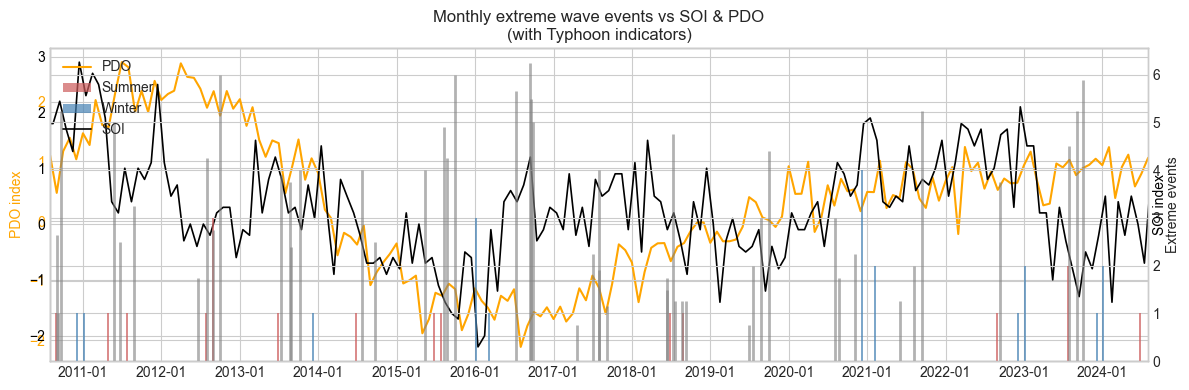

In [56]:
plot_event_soi_overlay(
    events=events,
    soi=soi,
    pdo=pdo,
    typhoon_df=closest[['closest_date','USA_WIND']],
    wind_scale=20.0
)

In [75]:
import statsmodels.api as sm
from patsy import dmatrices

def fit_lagged_glm(events: pd.DataFrame,
                   soi: pd.Series,
                   typhoon_df: pd.DataFrame,
                   start='2010-01',
                   end='2024-12'):
    """
    EW_count ~ Typhoon_dummy + SOI_{-1,0,+1} + Season_summer     (Poisson GLM)

    Parameters
    ----------
    events : DataFrame
        Must contain 'start' (datetime) and 'season' ('summer'/'winter').
    soi : pandas Series
        Monthly SOI (DatetimeIndex).
    typhoon_df : DataFrame
        Columns: 'closest_date' (datetime)  'USA_WIND' (numeric – already cleaned).
    start , end : str
        Analysis window (inclusive).
    """
    # -----------------------------------------------------------
    # 1. Create monthly skeleton
    # -----------------------------------------------------------
    months = pd.date_range(start, end, freq='MS')
    panel = pd.DataFrame(index=months)

    # 2. EW counts per month
    tmp = events.copy()
    tmp['month'] = tmp['start'].dt.to_period('M').dt.to_timestamp()
    ew_month = tmp.groupby('month').size()
    panel['EW_count'] = ew_month.reindex(months, fill_value=0)

    # 3. Typhoon dummy  (>=1 typhoon within 300 km in that month)
    typhoon_months = (pd.to_datetime(typhoon_df['closest_date'])
                      .dt.to_period('M').dt.to_timestamp())
    panel['Typhoon_dummy'] = panel.index.isin(typhoon_months).astype(int)

    # 4. SOI and its ±1-month shifts
    soi.index = soi.index.to_period("M").to_timestamp()
    soi = soi.reindex(months).interpolate()
    panel['SOI_0']      = soi
    panel['SOI_lag1']   = soi.shift(1)
    panel['SOI_lead1']  = soi.shift(-1)

    # 5. Season dummy (summer = Jun-Sep)
    panel['Season_summer'] = panel.index.month.isin([6,7,8,9]).astype(int)

    # Drop first/last row where lag/lead NA
    panel = panel.dropna()

    # -----------------------------------------------------------
    # 6. Poisson GLM via patsy
    # -----------------------------------------------------------
    formula = "EW_count ~ Typhoon_dummy + SOI_lag1 + SOI_0 + SOI_lead1 + Season_summer"
    y, X = dmatrices(formula, data=panel, return_type='dataframe')
    model = sm.GLM(y, X, family=sm.families.Poisson())
    res   = model.fit()

    print(res.summary())
    return res, panel


In [76]:
res, panel = fit_lagged_glm(
    events       = events,           # your EW event table
    soi          = soi['SOI'],       # monthly SOI
    typhoon_df   = closest[['closest_date', 'USA_WIND']],  # typhoon data
)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               EW_count   No. Observations:                  178
Model:                            GLM   Df Residuals:                      172
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -123.82
Date:                Wed, 25 Jun 2025   Deviance:                       175.74
Time:                        23:19:46   Pearson chi2:                     317.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06476
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5216      0.213     -7.159